In [1]:
import findspark
findspark.init('/afs/cern.ch/work/m/migliori/public/spark-2.4/')

In [2]:
application_name = 'test-RNN'
master = "local[8]"

from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .appName("RNN")\
        .config("spark.master", master)\
        .config("spark.driver.memory", "64G")\
        .config("spark.pyspark.python",
                "/afs/cern.ch/work/m/migliori/public/anaconda2/bin/python")\
        .config("spark.local.dir", "/local1/matteo")\
        .config("spark.sql.execution.arrow.enabled", "true")\
        .config("spark.driver.maxResultSize", "32G") \
        .getOrCreate()

In [33]:
data = spark.read.format("parquet") \
        .load("/afs/cern.ch/work/m/migliori/public/SparkPipeline/more_data.parquet") 
                
%time data.count()

CPU times: user 0 ns, sys: 238 µs, total: 238 µs
Wall time: 129 ms


58878

In [34]:
data.show(2)

+--------------------+--------------------+-----+
|           hfeatures|           lfeatures|label|
+--------------------+--------------------+-----+
|[125.582424163818...|[[62.019286629953...|    1|
|[453.637893676757...|[[174.23577757887...|    1|
+--------------------+--------------------+-----+
only showing top 2 rows



In [35]:
lf = data.select('lfeatures').take(1)[0].lfeatures

In [36]:
from __future__ import print_function

print('Number of particles',len(lf))
print('Number of features', len(lf[0]))

Number of particles 801
Number of features 19


Foreach event we need to sort particles by decreasing $\Delta R$ distance from the isolated lepton. Foreach event, the lepton is the first particle in the list. 

The features foreach particles are: <br>
['Energy', 'Px', 'Py', 'Pz', 'Pt', 'Eta', 'Phi', 'vtxX', 'vtxY', 'vtxZ', 'ChPFIso', 'GammaPFIso', 'NeuPFIso', 'isChHad', 'isNeuHad', 'isGamma', 'isEle',  'isMu', 'Charge'] <br>
hence to compute $\Delta R$ we need $\eta$ (feature $5$) and $\phi$ (feature $6$)

$$
\Delta R = \sqrt{\Delta \eta^2 + \Delta \phi^2}
$$

Let's test a way to sort the events

In [39]:
event = data.select('lfeatures').take(1)[0].lfeatures[:10]

In [40]:
import math

class lepAngularCoordinates():
 
    def __init__(self, eta, phi):
        self.Eta = eta
        self.Phi = phi
        
    def Phi_mpi_pi(self, x):
        while x >= 3.1415: 
            x -= 2*3.1415
        while x < -3.1415:
            x += 2*3.1415
        return x
        
    def DeltaR(self, eta, phi):
        deta = self.Eta - eta
        dphi = self.Phi_mpi_pi(self.Phi - phi)
        return math.sqrt(deta*deta + dphi*dphi)
    
lep = lepAngularCoordinates(event[0][5], event[0][6])

In [42]:
event.sort(key=lambda x: lep.DeltaR(x[5],x[6]), reverse=True)

In [43]:
for i in range(10):
    print(lep.DeltaR(event[i][5], event[i][6]))

3.75305560396
3.73184586116
3.61661026561
3.49645349958
3.35136543766
3.09919205665
3.05046729405
2.88620510021
2.78708877029
0.0


Now let's do the same for the entire dataset

In [44]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf

from sklearn.preprocessing import StandardScaler

@udf(returnType=ArrayType(ArrayType(DoubleType())))
def transform(particles):
    ## The isolated lepton is the first partiche in the list
    ISOlep = lepAngularCoordinates(particles[0][5], particles[0][6])
    
    ## Sort the particles based on the distance from the isolated lepton
    particles.sort(key = lambda part: ISOlep.DeltaR(part[5], part[6]),
                   reverse=True)
    
    ## Standardize
    particles = StandardScaler().fit_transform(particles).tolist()
    
    return particles

In [45]:
scaled_df = data.withColumn('scaled_features', transform('lfeatures'))

In [46]:
scaled_df.printSchema()

root
 |-- hfeatures: vector (nullable = true)
 |-- lfeatures: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- label: integer (nullable = true)
 |-- scaled_features: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [ ]:
%time scaled_df.write.parquet("RNN_data.parquet", mode="overwrite")

### Test the data loader

In [3]:
scaled_df = spark.read.format("parquet") \
        .load("file:///afs/cern.ch/work/m/migliori/public/SparkPipeline/RNN_data.parquet/")
scaled_df.count()

58878

In [4]:
from pyspark.ml.feature import OneHotEncoderEstimator

encoder = OneHotEncoderEstimator(inputCols=["label"],
                                 outputCols=["encoded_label"],
                                 dropLast=False)

transformer = encoder.fit(scaled_df)

In [5]:
# Encode the label
scaled_data = transformer.transform(scaled_df)

In [6]:
train, test = scaled_data.randomSplit([0.8, 0.2])

In [7]:
from  pyspark.sql.functions import rand 
train = train.orderBy(rand()).cache()
train.select(['label', 'encoded_label']).show(5)

+-----+-------------+
|label|encoded_label|
+-----+-------------+
|    2|(3,[2],[1.0])|
|    2|(3,[2],[1.0])|
|    2|(3,[2],[1.0])|
|    2|(3,[2],[1.0])|
|    1|(3,[1],[1.0])|
+-----+-------------+
only showing top 5 rows



In [8]:
%%time
print('Events for the training {}'.format(train.count()))
print('Events for the validation {}'.format(test.count()))

Events for the training 47272
Events for the validation 11606
CPU times: user 6.55 ms, sys: 7.8 ms, total: 14.4 ms
Wall time: 37.1 s


## Build the RNN

In [9]:
import numpy as np

In [10]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, merge, Input, LSTM, Masking,GRU, merge
from keras import regularizers, optimizers

Using TensorFlow backend.


In [11]:
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(None,19)))
model.add(GRU(units=50,
              recurrent_dropout=0.2,
              activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 19)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                10500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 10,653
Trainable params: 10,653
Non-trainable params: 0
_________________________________________________________________


In [12]:
from distkeras.trainers import * 
from distkeras.predictors import *
from distkeras.utils import *
from distkeras.workers import *

In [13]:
optimizer = 'adam'
loss = 'categorical_crossentropy'

num_epochs = 50 
batch_size = 200

## set the number of workers
num_workers = 7

In [14]:
trainer = AEASGD(keras_model=model, worker_optimizer=optimizer,
                 loss=loss, num_workers=num_workers, batch_size=batch_size,
                 features_col="scaled_features", label_col="encoded_label", num_epoch=num_epochs,
                 communication_window=32, rho=5.0, learning_rate=0.1,
                 master_port=5500)
trainer.set_parallelism_factor(1)

In [15]:
%time trained_model = trainer.train(train)

CPU times: user 24min 12s, sys: 9min 16s, total: 33min 28s
Wall time: 34min 9s


## Plot worker iterations

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib notebook

In [17]:
worker_id = []
worker_iterations = []
worker_trainer = []

trainers_list = [trainer]
trainers_name = ['AEASGD']

for t, t_name in zip(trainers_list, trainers_name):
    for i in range(t.get_num_workers()):
        worker_id.append(i)
        worker_iterations.append(len(t.get_executor_history(i)))
        worker_trainer.append(t_name)
        
trainer_dataframe = pd.DataFrame({'worker_id':worker_id,
                                  'worker_iterations':worker_iterations,
                                  'trainer':worker_trainer})
trainer_dataframe.head()

,trainer,worker_id,worker_iterations
0,AEASGD,0,1700
1,AEASGD,1,1700
2,AEASGD,2,1700
3,AEASGD,3,1700
4,AEASGD,4,1650


<IPython.core.display.Javascript object>


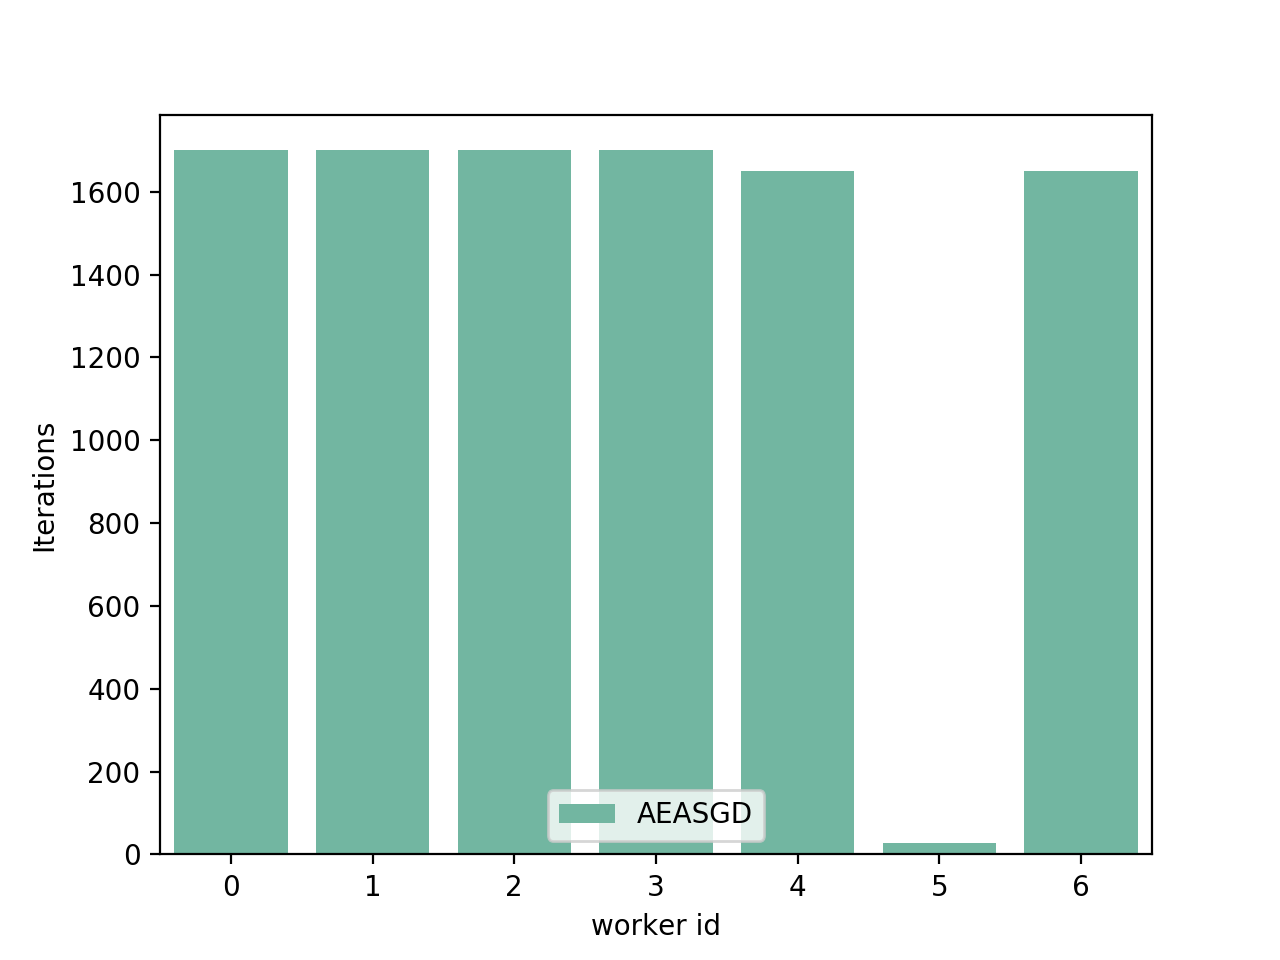

In [51]:
%matplotlib notebook 
plt.figure()
sns.barplot(x='worker_id', y='worker_iterations', hue='trainer',
              data=trainer_dataframe, palette="Set2")
plt.legend(loc='lower center')
plt.xlabel('worker id')
plt.ylabel('Iterations')
plt.show()

## Plot loss 

In [19]:
def compute_trainer_metrics(trainer):
    
    ## Get the history of each executor and find the max number of iterations
    num_workers = trainer.get_num_workers()
    max_iterations = 0
    
    history = []
    
    for i in range(num_workers):
        history.append(trainer.get_executor_history(i))
        if history[i][-1]['iteration']>max_iterations:
            max_iterations = history[i][-1]['iteration']
            
    iteration = []
    avg_loss = []
    std_loss = []

    ## Average the losses of batch_size iterations
    batch_loss = []
    batch_std = []
    
    for i in range(max_iterations):
        loss_i = [h[i]['history'][0] for h in history if i<len(h)]
        batch_loss.append(np.mean(loss_i))
        batch_std.append(np.std(loss_i))
    
        if (i%100==0) or (i==max_iterations-1):
            iteration.append(i)
            avg_loss.append(np.mean(batch_loss))
            std_loss.append(np.mean(batch_std))
            batch_loss = []
            batch_std = []
    
    iteration = np.asarray(iteration)
    loss = np.asarray(avg_loss)
    error = np.asarray(std_loss)
    
    return iteration, loss, error

In [20]:
x, y, err = compute_trainer_metrics(trainer)

<IPython.core.display.Javascript object>


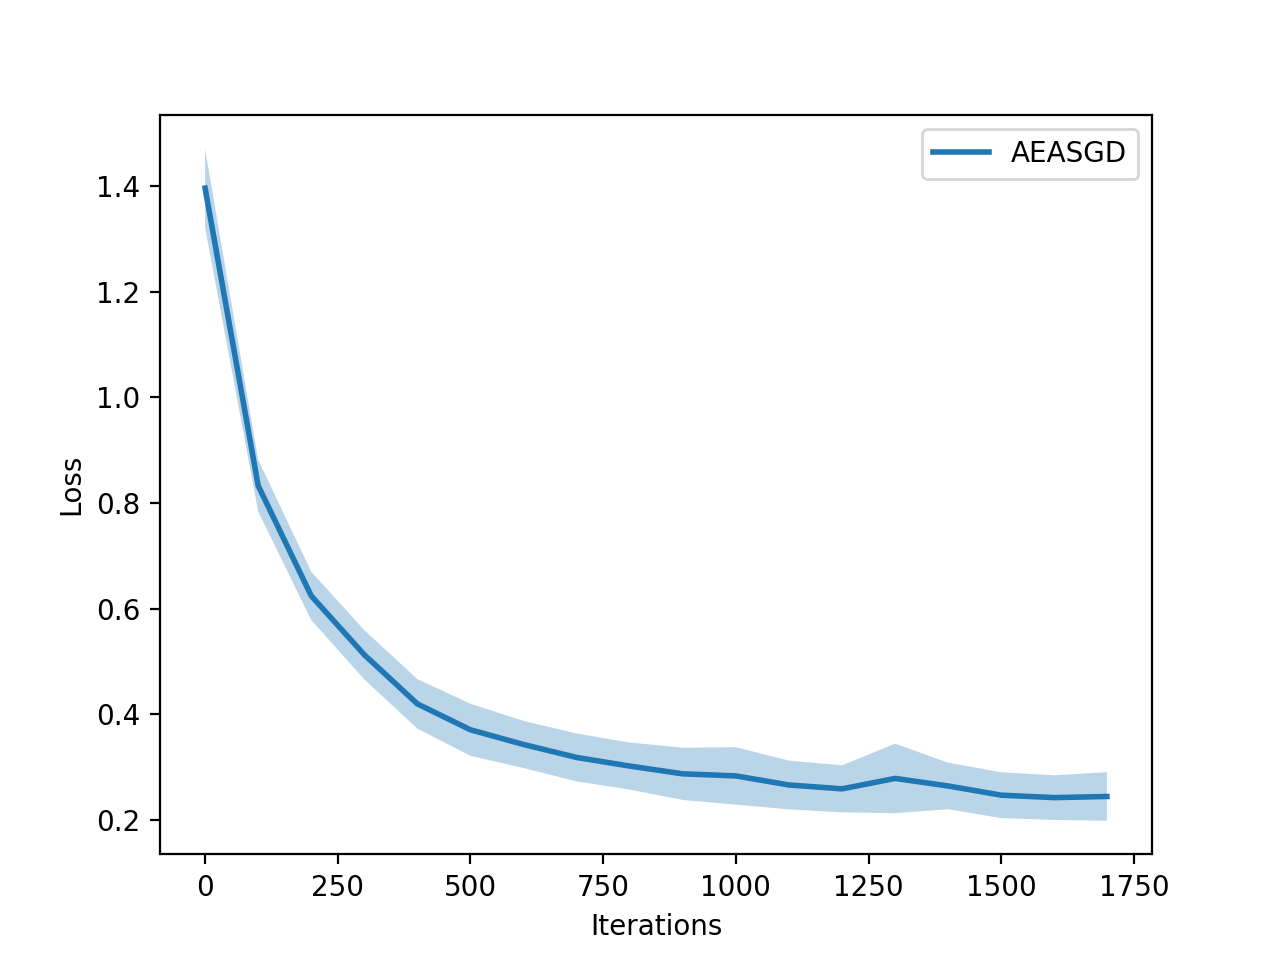

In [21]:
plt.figure()
plt.plot(x, y, lw=2, label='AEASGD')
plt.fill_between(x, y - err , y + err, alpha=0.3)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save the model

In [22]:
trained_model.save('gru_model.h5')

In [23]:
from keras.models import load_model
loaded_model = load_model('gru_model.h5')

/afs/cern.ch/work/m/migliori/public/anaconda2/lib/python2.7/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Predictions

In [24]:
predictor = ModelPredictor(keras_model=loaded_model, features_col='scaled_features')
pred = predictor.predict(test)

In [25]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf
    
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))
pred = pred.select([vector_udf('encoded_label').alias('encoded_label'),
                    vector_udf('prediction').alias('prediction')])

%time pred_pd = pred.toPandas()

CPU times: user 45.5 ms, sys: 30.6 ms, total: 76 ms
Wall time: 2min 45s


In [26]:
y_true = np.array(pred_pd['encoded_label'].tolist())
y_pred = np.array(pred_pd['prediction'].tolist())

In [27]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


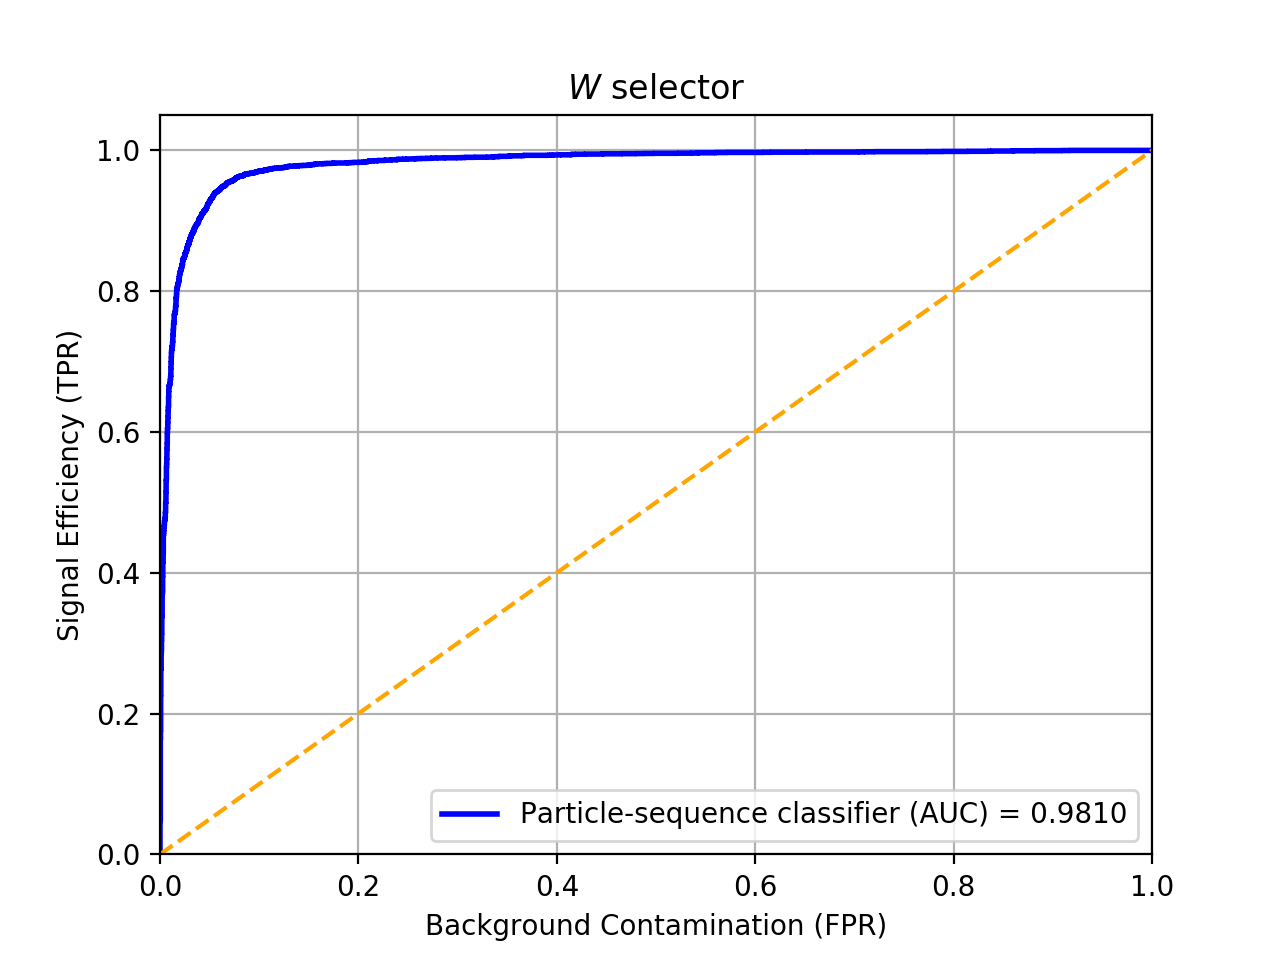

In [53]:
plt.figure()
plt.plot(fpr[1], tpr[1], color='blue',
         lw=2, label='Particle-sequence classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()